<a href="https://colab.research.google.com/github/ollihansen90/MatheSH-StatLern/blob/main/ImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def add_obj(img, obj, pos, use_pad=True, use_overlap=True):
    k, j = obj.shape
    if use_pad:
        out = np.pad(img.copy(), (k,j))
    else:
        out = img.copy()
    patch = out[pos[0]:pos[0]+k, pos[1]:pos[1]+j]
    if np.sum(patch)>0 and not use_overlap:
        return img
    patch[obj>0] = obj.max()
    out[pos[0]:pos[0]+k, pos[1]:pos[1]+j] = patch
    if use_pad:
        out = out[k:-k, j:-j]
    return out

def circle(d=11, label=1):
    base = np.expand_dims(np.linspace(-1,1,d)**2, axis=0)
    out = ((base+base.T)<=1).astype(int)
    #print(out)
    return out

def square(d=11, label=2):
    out = label*np.ones([d,d])
    return out

def rgbfy(img):
    out = np.zeros((*img.shape, 3))
    for i in range(3):
        out[:,:,i] = (img==i).astype(int)
    return out

def img_generator(
        x=2**9,
        y=2**9,
        d_min=50,
        d_max=100,
        use_overlap=False,
        use_pad=False,
        N_max=10,
        thresh=0.5,
        ):
    img = np.zeros([x, y])
    x, y = img.shape

    for _ in range(N_max):
        d = np.random.randint(d_min, d_max)
        if use_pad:
            xx, yy = np.random.randint(0,x+d), np.random.randint(0,y+d)
        else:
            xx, yy = np.random.randint(0,x-d), np.random.randint(0,y-d)
        if np.random.rand()>thresh:
            #print("Kreis")
            img = add_obj(img, circle(d=d), [xx,yy], use_pad=use_pad, use_overlap=use_overlap)
        else:
            #print("Quadrat")
            img = add_obj(img, square(d=d), [xx,yy], use_pad=use_pad, use_overlap=use_overlap)
    return img

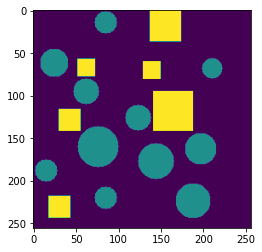

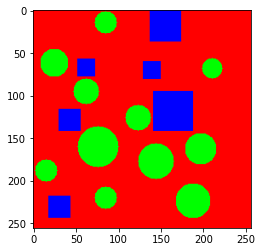

In [ ]:
"""x, y = 2**9, 2**9
d_min, d_max = 50, 100
use_overlap = False
use_pad = False
N = 10

img = np.zeros([x, y])

for _ in range(N):
    d = np.random.randint(d_min, d_max)
    if use_pad:
        xx, yy = np.random.randint(0,2**9+d), np.random.randint(0,2**9+d)
    else:
        xx, yy = np.random.randint(0,2**9-d), np.random.randint(0,2**9-d)
    if np.random.rand()>0.5:
        #print("Kreis")
        img = add_obj(img, circle(d=d), [xx,yy], use_pad=use_pad, use_overlap=use_overlap)
    else:
        #print("Quadrat")
        img = add_obj(img, square(d=d), [xx,yy], use_pad=use_pad, use_overlap=use_overlap)"""
img = img_generator(x=2**8, y=2**8, d_min=20, d_max=50, N_max=50)

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
plt.imshow(rgbfy(img))
plt.show()

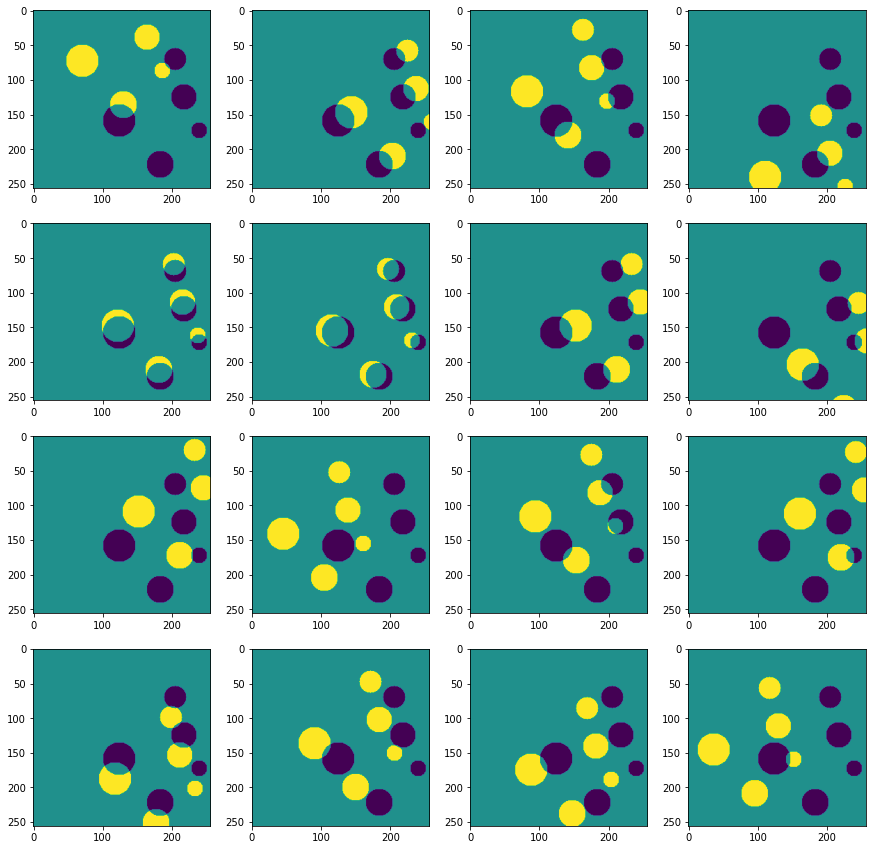

In [ ]:
class GeneralConv():
    def __init__(self, n_kernels=8, n_diffkernels=8, offset=50):
        self.n_kernels = n_kernels
        self.n_diffkernels = n_diffkernels
        self.transl = offset*np.random.randn(n_kernels, 2)
        self.transl_diffs = offset*np.random.randn(2*n_kernels, 2)

    def __call__(self, img):
        xx, yy = img.shape
        out = np.zeros((xx,yy,self.n_kernels+self.n_diffkernels))
        img_padded = np.pad(img, (xx, yy))
        for i in range(self.n_kernels):
            pos = self.transl[i].astype(int)
            out[:,:,i] = img_padded[xx+pos[0]:2*xx+pos[0],yy+pos[1]:2*yy+pos[1]]-img

        for i in range(self.n_diffkernels):
            pos1 = self.transl_diffs[2*i].astype(int)
            pos2 = self.transl_diffs[2*i+1].astype(int)
            img1 = img_padded[xx+pos1[0]:2*xx+pos1[0],yy+pos1[1]:2*yy+pos1[1]]
            img2 = img_padded[xx+pos2[0]:2*xx+pos2[0],yy+pos2[1]:2*yy+pos2[1]]
            out[:,:,i+self.n_kernels] = img1-img2
        return out

GenConv = GeneralConv(n_kernels=32, n_diffkernels=32)
imglist = GenConv(img)

plt.figure(figsize=[15,15])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imglist[:,:,i])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

class MLP(nn.Module):
    def __init__(self, in_dim=64, out_dim=3, hidden_dims=[32,16,8]):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.layers.append(nn.Linear(in_dim, hidden_dims[0]))
        self.layers.append(nn.ReLU())
        for i in range(1,len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_dims[-1], out_dim))
        #self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = MLP().to(device)
print(model)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


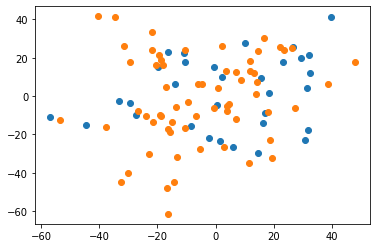

0 0.3615


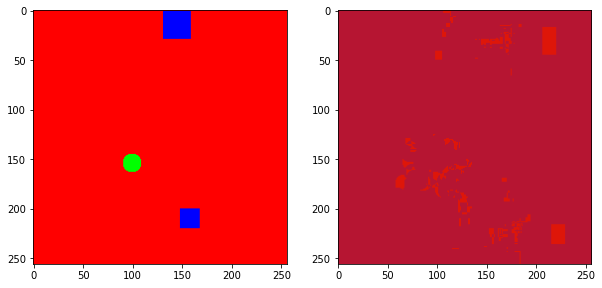

50 0.3757
100 0.3876
150 0.4049


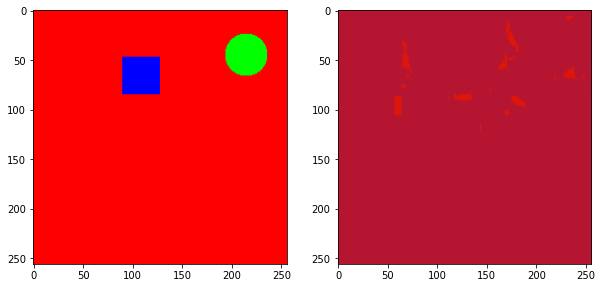

200 0.3915
250 0.403
300 0.4003


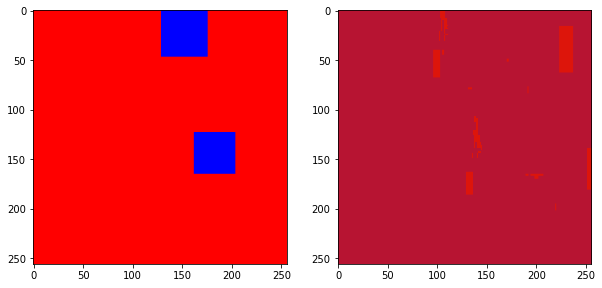

350 0.4017
400 0.3893
450 0.3913


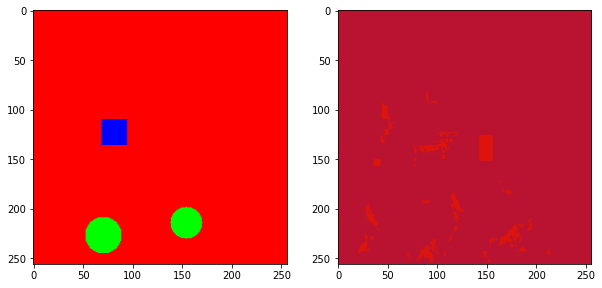

500 0.3854
550 0.3901
600 0.3976


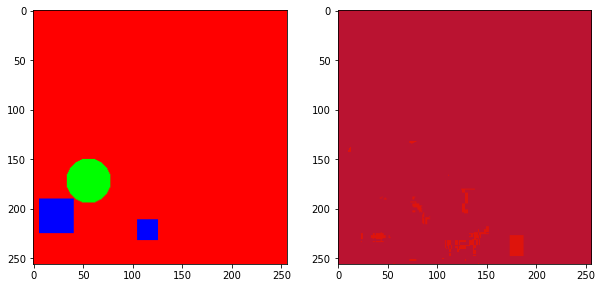

650 0.3773
700 0.3673
750 0.3517


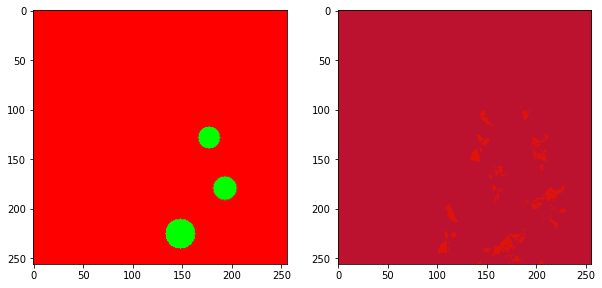

800 0.4297
850 0.3796
900 0.3441


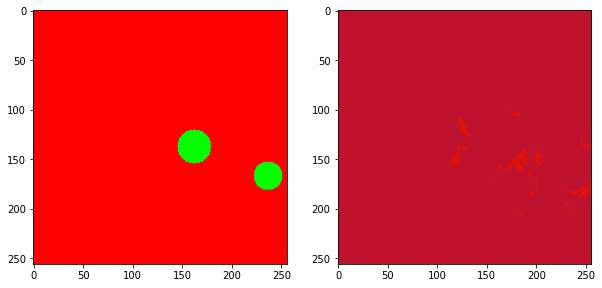

950 0.3654
1000 0.3305
1050 0.3359


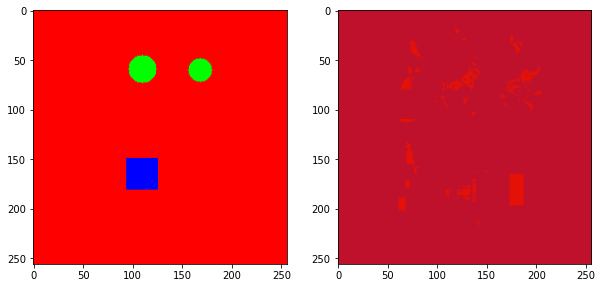

1100 0.3784
1150 0.3587
1200 0.3539


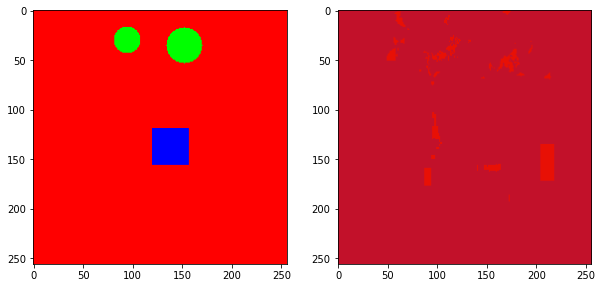

1250 0.3687
1300 0.3337
1350 0.3082


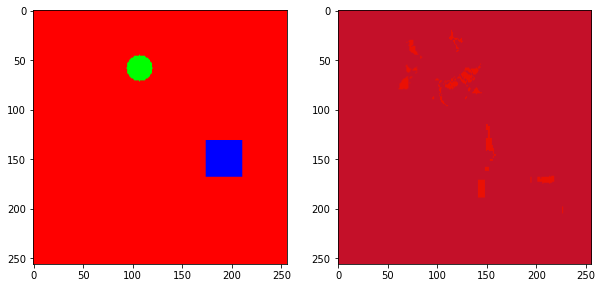

1400 0.3267
1450 0.3286
1500 0.322


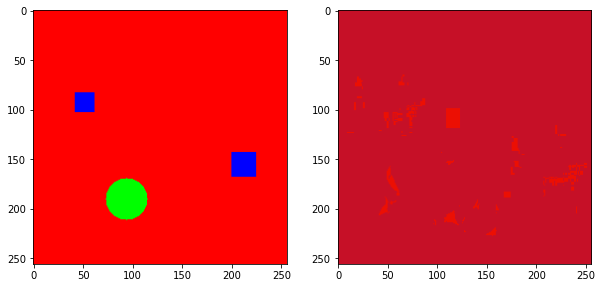

1550 0.3642
1600 0.3332
1650 0.372


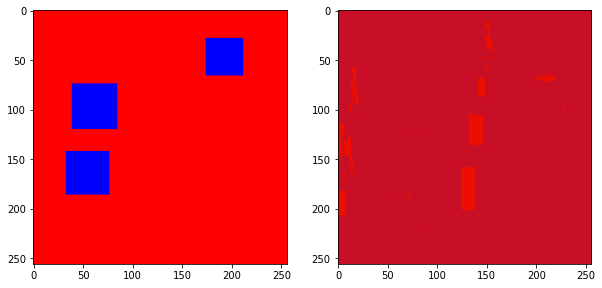

1700 0.3179
1750 0.3135
1800 0.3486


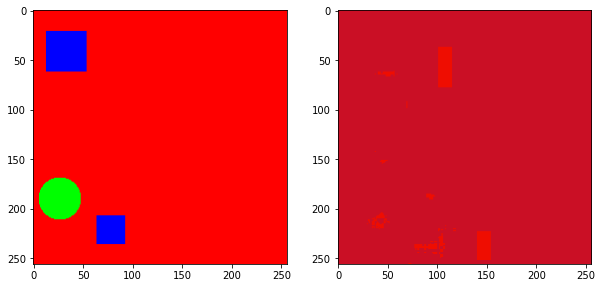

1850 0.3238
1900 0.2548
1950 0.3473


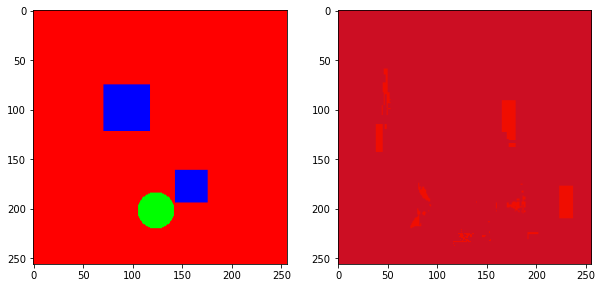

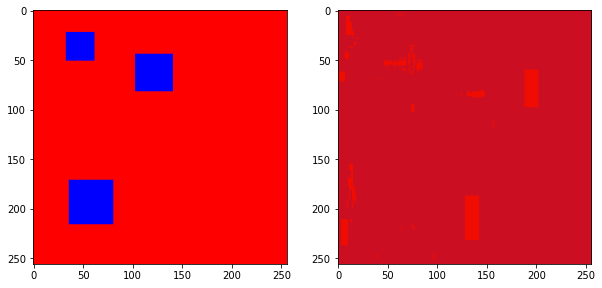

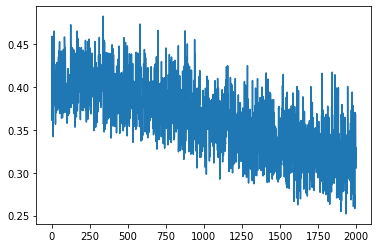

In [ ]:
n_epochs = 2000
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
GenConv = GeneralConv(n_kernels=32, n_diffkernels=32, offset=20)
plt.figure()
plt.scatter(GenConv.transl[:,0], GenConv.transl[:,1])
plt.scatter(GenConv.transl_diffs[:,0], GenConv.transl_diffs[:,1])
plt.show()

vert = 3*[0]+[0.5]+3*[1]
vert = 2*[0.5]
x=2**8
y=2**8
d_min=20
d_max=50
NN = 4

losslist = torch.zeros(n_epochs)

model.train()
for epoch in range(n_epochs):
    img = img_generator(x=x, y=y, d_min=d_min, d_max=d_max, N_max=np.random.randint(3,NN), thresh=vert[int(epoch%len(vert))])
    data = torch.tensor(GenConv(img)).float().flatten(start_dim=0, end_dim=1)
    output = model(data.to(device))
    loss = F.cross_entropy(output, torch.tensor(rgbfy(img)).float().flatten(start_dim=0, end_dim=1).to(device))
    loss.backward()
    optimizer.step()
    if epoch%50==0:
        print(epoch, round(loss.item(), ndigits=4))
    if epoch%150==0:
        plt.figure(figsize=[10,6])
        plt.subplot(1,2,1)
        plt.imshow(rgbfy(img))
        plt.subplot(1,2,2)
        plt.imshow(F.softmax(output, dim=-1).detach().reshape(2**8,2**8,3).cpu().numpy())
        plt.show()
    losslist[epoch] = loss.item()

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.imshow(rgbfy(img))
plt.subplot(1,2,2)
plt.imshow(F.softmax(output, dim=-1).detach().reshape(2**8,2**8,3).cpu().numpy())
plt.show()
plt.figure()
plt.plot(losslist)
plt.show()



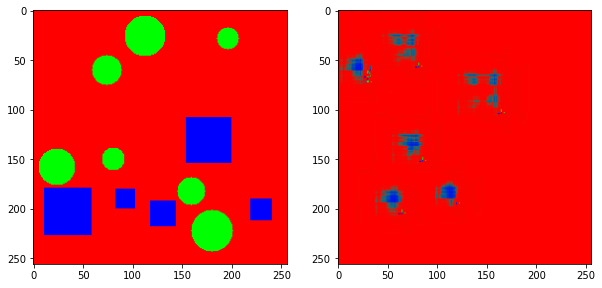

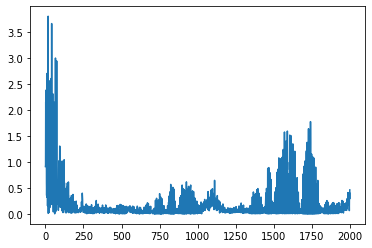

In [ ]:
img = img_generator(x=2**8, y=2**8, d_min=20, d_max=50, N_max=20)
plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.imshow(rgbfy(img))
plt.subplot(1,2,2)
plt.imshow(F.softmax(output, dim=-1).detach().reshape(2**8,2**8,3).cpu().numpy())
plt.show()
plt.figure()
plt.plot(losslist)
plt.show()